In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
#pd.options.plotting.backend = "plotly"
#import xarray as xr
import hvplot.pandas  # noqa
#import hvplot.xarray  # noqa
from bokeh.plotting import show
import holoviews as hv



Bad key "text.kerning_factor" on line 4 in
C:\Users\goshl\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [15]:
Housing_Data = pd.read_csv(r"C:\Users\goshl\OneDrive\Documents\GitHub\kc_house_data.csv")
Housing_Data = Housing_Data.drop(["id"], axis = 1).set_index("date")
#Housing_Data = Housing_Data[["price", 'sqft_living']]
Housing_Data = Housing_Data.sort_index()
Housing_Data.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
date                                                                            
20140502T000000  437500.0         3       2.25         1970     35100     2.0   
20140502T000000  790000.0         3       2.50         2600      4750     1.0   
20140502T000000  675000.0         5       2.50         2820     67518     2.0   
20140502T000000  555000.0         4       2.50         3310      6500     2.0   
20140502T000000  440000.0         4       2.25         2160      8119     1.0   

                 waterfront  view  condition  grade  sqft_above  \
date                                                              
20140502T000000           0     0          4      9        1970   
20140502T000000           0     0          4      9        1700   
20140502T000000           0     0          3      8        2820   
20140502T000000           0     0          3      8        3310   
20140502T000000           0     0          3      8        1080   

                 sqft_basement  yr_built  yr_renovated  zipcode      lat  \
date                                                                       
20140502T000000              0      1977             0    98027  47.4635   
20140502T000000            900      1951             0    98117  47.6833   
20140502T000000              0      1979             0    98029  47.5794   
20140502T000000              0      2012             0    98065  47.5150   
20140502T000000           1080      1966             0    98006  47.5443   

                    long  sqft_living15  sqft_lot15  
date                                                 
20140502T000000 -121.991           2340       35100  
20140502T000000 -122.400           2380        4750  
20140502T000000 -122.025           2820       48351  
20140502T000000 -121.870           2380        5000  
20140502T000000 -122.177           1850        9000

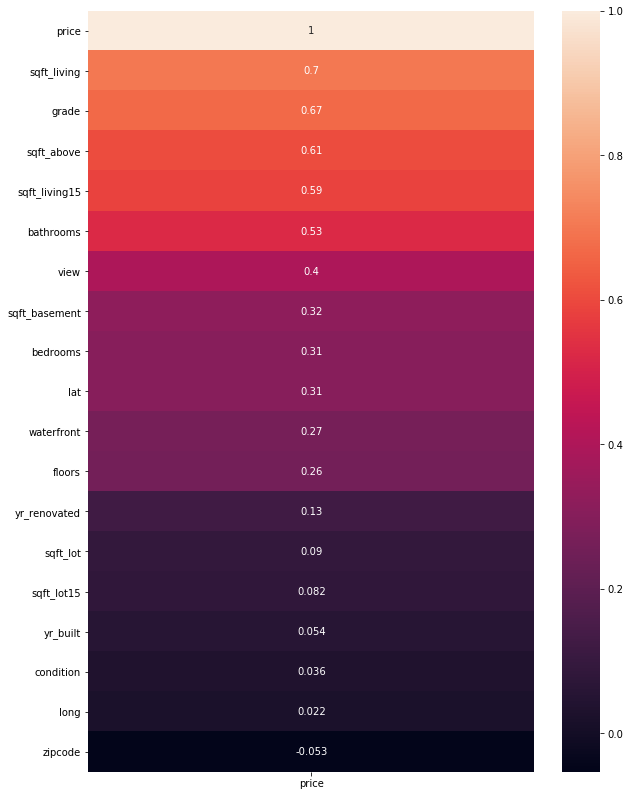

In [16]:
fig, ax = plt.subplots(figsize=(10,14))
price_corr = Housing_Data.corr()[['price']].sort_values(by='price', ascending=False)
sns.heatmap(price_corr, annot=True, ax=ax) 

In [17]:
housing_data_column_name = list(Housing_Data.columns)
housing_data_column_name


['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [18]:
Housing_Data_subplot = Housing_Data.hvplot.scatter(x='price', y=housing_data_column_name, width=350, height=300, subplots=True, shared_axes=False).cols(6)
show(hv.render(Housing_Data_subplot))

In [21]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = Housing_Data.iloc[i : (i + window), feature_col_number]
        target = Housing_Data.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(Housing_Data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))




model.compile(optimizer="adam", loss="mean_squared_error")



model.summary()

model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)


predicted = model.predict(X_test)


predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

X sample values:
[[ 437500.  790000.  675000.  555000.  440000.  295000.  470000.  550000.
   313000.  626000.  285000.  612500.  400000.  495000.  407500.  385000.
   490000.  445700.  335000.  625000.  650000.  463000.  640000.  499950.
   300000.  435000.  750000.  235000.  382500.  625000.]
 [ 790000.  675000.  555000.  440000.  295000.  470000.  550000.  313000.
   626000.  285000.  612500.  400000.  495000.  407500.  385000.  490000.
   445700.  335000.  625000.  650000.  463000.  640000.  499950.  300000.
   435000.  750000.  235000.  382500.  625000. 2384000.]
 [ 675000.  555000.  440000.  295000.  470000.  550000.  313000.  626000.
   285000.  612500.  400000.  495000.  407500.  385000.  490000.  445700.
   335000.  625000.  650000.  463000.  640000.  499950.  300000.  435000.
   750000.  235000.  382500.  625000. 2384000.  315000.]] 

y sample values:
[[2384000.]
 [ 315000.]
 [ 459990.]]
Model: "sequential_3"
_________________________________________________________________
L

In [22]:
pridicted_price1 = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = Housing_Data.index[-len(real_prices): ]) 

# Show the DataFrame's head
pridicted_price1.tail()

Actual     Predicted
date                                    
20150514T000000   183000.0  512893.00000
20150514T000000   359000.0  512790.21875
20150515T000000   450000.0  512567.75000
20150524T000000   445500.0  512336.31250
20150527T000000  1310000.0  512131.93750

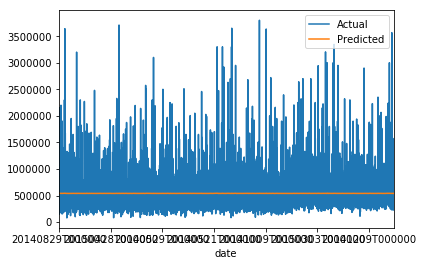

In [29]:
pridicted_price1.plot()

In [23]:
new_Housing_Data = Housing_Data[["price", 'sqft_living']]

In [29]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = new_Housing_Data.iloc[i : (i + window), feature_col_number]
        target = new_Housing_Data.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(new_Housing_Data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


model = Sequential()

# Initial model setup
number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))




model.compile(optimizer="adam", loss="mean_squared_error")



model.summary()

model.fit(X_train, y_train, epochs=5, shuffle=False, batch_size=90, verbose=1)


predicted = model.predict(X_test)


predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

X sample values:
[[ 437500.  790000.  675000.  555000.  440000.  295000.  470000.  550000.
   313000.  626000.  285000.  612500.  400000.  495000.  407500.  385000.
   490000.  445700.  335000.  625000.  650000.  463000.  640000.  499950.
   300000.  435000.  750000.  235000.  382500.  625000.]
 [ 790000.  675000.  555000.  440000.  295000.  470000.  550000.  313000.
   626000.  285000.  612500.  400000.  495000.  407500.  385000.  490000.
   445700.  335000.  625000.  650000.  463000.  640000.  499950.  300000.
   435000.  750000.  235000.  382500.  625000. 2384000.]
 [ 675000.  555000.  440000.  295000.  470000.  550000.  313000.  626000.
   285000.  612500.  400000.  495000.  407500.  385000.  490000.  445700.
   335000.  625000.  650000.  463000.  640000.  499950.  300000.  435000.
   750000.  235000.  382500.  625000. 2384000.  315000.]] 

y sample values:
[[2384000.]
 [ 315000.]
 [ 459990.]]
Model: "sequential_6"
_________________________________________________________________
L

In [30]:
pridicted_price2 = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = new_Housing_Data.index[-len(real_prices): ]) 

# Show the DataFrame's head
pridicted_price2.head()

Actual     Predicted
date                                   
20150116T000000  400000.0  511862.62500
20150116T000000  560000.0  511924.03125
20150116T000000  447500.0  512011.50000
20150116T000000  919000.0  511941.68750
20150116T000000  330000.0  512308.84375

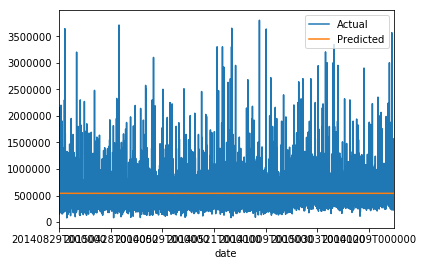

In [30]:
pridicted_price2.plot()

In [36]:
price_corr

price
price          1.000000
sqft_living    0.702035
grade          0.667434
sqft_above     0.605567
sqft_living15  0.585379
bathrooms      0.525138
view           0.397293
sqft_basement  0.323816
bedrooms       0.308350
lat            0.307003
waterfront     0.266369
floors         0.256794
yr_renovated   0.126434
sqft_lot       0.089661
sqft_lot15     0.082447
yr_built       0.054012
condition      0.036362
long           0.021626
zipcode       -0.053203